<a href="https://colab.research.google.com/github/Biniyamgd/IDP/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#progress

!pip install dlib
!pip install face_recognition

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


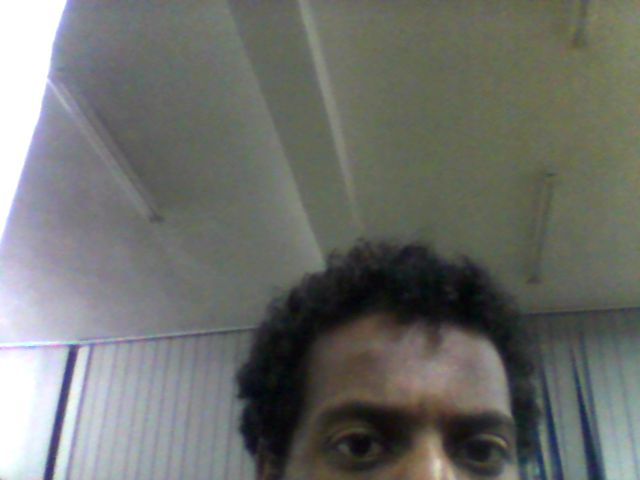

In [3]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<function matplotlib.pyplot.show(close=None, block=None)>

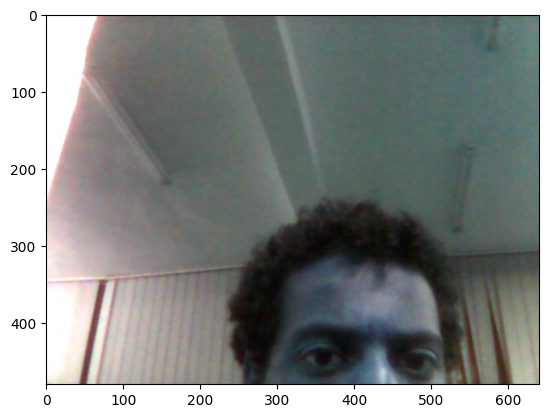

In [4]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
img= cv2.imread('./photo.jpg')
plt.imshow(img)
plt.show

In [32]:
import cv2
import os
import dlib
import face_recognition

filepath='./'
folder=os.listdir(filepath)
modelist=[]
stuid=[]
encodeList=[]
for Path in folder:
  modelist.append(cv2.imread(os.path.join(filepath,Path)))
  if '.jpg' in Path:
    stuid.append(os.path.splitext(Path)[0])
    print(stuid)

def encodingImg(img):
  for i in img:
    i=cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(i)[0]
    encodeList.append(encode)

  return encodeList


print('encoding Started...')
encodes=encodingImg(modelist)
print('encoding Complete...')
print(encodes)


RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /tmp/pip-install-lrm8f3la/dlib_a8457957935d4f868f0bee5b450715aa/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

In [26]:
import os
# os.mkdir('./encoding')
# os.chdir('./encoding')
!touch encodeGenerator.py

In [ ]:
# import os
# os.chdir('./encoding')
open('encodeGenerator.py')


<_io.TextIOWrapper name='encodeGenerator.py' mode='r' encoding='UTF-8'>

In [18]:
import os
import cv2
filepath='./'
folder=os.listdir(filepath)
modelist=[]
modelist.append(cv2.imread(os.path.join(filepath,'photo.jpg')))
print(modelist)


[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 94, 123, 130],
        [ 93, 122, 129]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 96, 125, 132],
        [ 95, 124, 131]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 96, 126, 131],
        [ 98, 126, 133],
        [ 98, 125, 135]],

       ...,

       [[218, 218, 212],
        [222, 222, 216],
        [230, 227, 222],
        ...,
        [169, 162, 145],
        [170, 161, 147],
        [175, 166, 152]],

       [[199, 198, 194],
        [208, 207, 203],
        [221, 218, 214],
        ...,
        [172, 165, 150],
        [171, 162, 149],
        [175, 163, 151]],

       [[180, 178, 177],
        [193, 191, 190],
        [210, 206, 205],
        ...,
        [173, 166, 151],
        [172, 160, 150],
        [172, 160, 150]